In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default') # set style (colors, background, size, gridlines etc.) # ggplot
plt.rcParams['figure.figsize'] = 8, 4 # set default size of plots
plt.rcParams.update({'font.size': 18})

import scraping_class
logfile = 'log.txt' ## name your log file.
connector = scraping_class.Connector(logfile)

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

#pip install cpi
import cpi # inflation adjuster
#cpi.update()

In [130]:
# read in IMDb dataset
movies = pd.read_csv('IMDb movies.csv')

#### IMDb - Remove duplicates and all years before 1990

In [131]:
movies_90 = movies[movies.year >= 1990] # (53368, 22)
movies_90['title'] = movies_90['title'].astype(str)
movies_90 = movies_90.drop_duplicates(subset = 'title')

#### RT - Remove duplicates 

In [132]:
# read in Rotten Tomatoes dataset
df_RT = pd.read_csv('RT.csv').drop_duplicates(subset = 'title')

# merge datasets and drop duplicates
df_90 = pd.merge(movies_90,df_RT,how='inner',on='title')
df_90 = df_90.drop_duplicates()

In [133]:
# remove NaN 
df_90_income = df_90.dropna(subset = ['worlwide_gross_income']).reset_index(drop=True).drop_duplicates()

# show DataFrame
df_90_income

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,tomatometer_score,audience_score
0,tt0035423,Kate & Leopold,Kate & Leopold,2001,2002-04-05,"Comedy, Fantasy, Romance",118,USA,"English, French",James Mangold,...,6.4,75298,$ 48000000,$ 47121859,$ 76019048,44.0,330.0,127.0,50%,62%
1,tt0098994,"After Dark, My Sweet","After Dark, My Sweet",1990,1990-08-24,"Crime, Drama, Mystery",114,USA,English,James Foley,...,6.6,3019,NaN,$ 2678414,$ 2678414,78.0,46.0,28.0,82%,61%
2,tt0099005,Air America,Air America,1990,1991-02-22,"Action, Comedy, War",113,USA,"English, Lao",Roger Spottiswoode,...,5.8,25683,$ 35000000,$ 31053601,$ 33461269,33.0,49.0,28.0,13%,34%
3,tt0099012,Alice,Alice,1990,1991-01-10,"Comedy, Romance",106,USA,"English, Cantonese",Woody Allen,...,6.6,12574,$ 12000000,$ 7331647,$ 7331647,67.0,65.0,59.0,75%,57%
4,tt0099018,Almost an Angel,Almost an Angel,1990,1990-12-27,"Comedy, Drama",95,USA,English,John Cornell,...,5.5,3760,$ 25000000,$ 6939946,$ 6939946,NaN,26.0,10.0,29%,48%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245,tt9109306,The Final Wish,The Final Wish,2018,2019-01-24,Horror,95,USA,English,Timothy Woodward Jr.,...,4.2,2342,NaN,$ 25183,$ 82959,NaN,78.0,18.0,73%,26%
7246,tt9206798,All Is True,All Is True,2018,2019-02-08,"Biography, Drama, History",101,UK,English,Kenneth Branagh,...,6.1,1956,NaN,$ 1200481,$ 3019143,59.0,62.0,64.0,72%,67%
7247,tt9352926,The Sound of Silence,The Sound of Silence,2019,2019-09-13,Drama,85,USA,English,Michael Tyburski,...,5.3,426,NaN,$ 20013,$ 21994,66.0,14.0,15.0,65%,Nan
7248,tt9354944,Jexi,Jexi,2019,2019-10-11,Comedy,84,USA,English,"Jon Lucas, Scott Moore",...,6.6,3674,$ 5000000,$ 6546159,$ 7257918,39.0,46.0,24.0,17%,71%


#### Cleaning dataset and adjusting income and budget for inflation (CPI)

In [7]:
def inflate_column(data, column):
    '''Inflate monetary figures from a given year to their 2018 values'''
    return data.apply(lambda x: cpi.inflate(x[column], x.year), axis=1)

In [8]:
# remove all currency signs and dropping movies which revenue is not in dollars
df_90_income['worldwide_gross_income'] = df_90_income['worlwide_gross_income']\
                                        .apply(lambda x:x[1:] if x and x[:1]== '$' else None)

df_90_income = df_90_income.drop('worlwide_gross_income', axis=1)

# drop NaN for worldwide gross income 
df_90_income = df_90_income.dropna(subset = ['worldwide_gross_income'])

In [9]:
# repeat for budget
df_90_income = df_90_income.dropna(subset = ['budget'])
df_90_income['budget'] = df_90_income['budget'].apply(lambda x:x[1:] if x and x[:1]== '$' else None)

In [10]:
df_90_income = df_90_income.reset_index(drop=True).drop_duplicates()

# convert wgi to integer and drop years before 2019
df_90_income['worldwide_gross_income'] = df_90_income['worldwide_gross_income'].astype(int)
df_90_income = df_90_income[df_90_income.year <= 2018]

# inflate wgi to 2018 prices
df_90_income['adjusted_wgi'] = inflate_column(df_90_income, 'worldwide_gross_income')


# repeat for budget
df_budget = df_90_income.dropna(subset = ['budget']).copy()
df_budget.budget = df_budget.budget.astype(int)
df_budget['adjusted_budget'] = inflate_column(df_budget, 'budget')

# calculate net income
df_budget['net_income'] = df_budget.adjusted_wgi - df_budget.adjusted_budget

df = df_budget.reset_index(drop=True)
df # show

In [12]:
# Converting Rotten Tomatoes scores to floats
df['tomatometer_score'] = df['tomatometer_score'].replace({'\%':''}, regex = True)
df['audience_score'] = df['audience_score'].replace({'\%':''}, regex = True)

df['tomatometer_score']= df['tomatometer_score'].astype(float)
df['audience_score']= df['audience_score'].astype(float)

#### Calculating average scores for directors and writers

In [13]:
writers = list(df['director'].values)
director_scores = []
a = {}
for director in tqdm(directors):
    a[director] = pd.DataFrame(df[df['director'].str.contains(director)]) # 
    director_scores.append([director,
                           a[director]['avg_vote'].mean(),
                           a[director]['metascore'].mean(),
                           a[director]['tomatometer_score'].mean(),
                           a[director]['audience_score'].mean()])

In [14]:
cols = ['director', 'director_imdb', 'director_metascore', 'director_tomatometer', 'director_audience']
df_director = pd.DataFrame(director_scores, index=range(len(director_scores)),columns=cols)

In [15]:
len(directors)

4354

In [16]:
#writers = list(df.dropna(subset = ['writer'])['writer'].values)
#writers = list(df['writer'].values)
df = df.dropna(subset = ['writer'])

In [17]:
writers = list(df['writer'].values)
writer_scores = []
a = {}
for writer in tqdm(writers):
    
    a[writer] = pd.DataFrame(df[df['writer'].str.contains(writer)])
    writer_scores.append([writer,
                           a[writer]['avg_vote'].mean(),
                           a[writer]['metascore'].mean(),
                           a[writer]['tomatometer_score'].mean(),
                           a[writer]['audience_score'].mean()])

In [18]:
cols = ['writer', 'writer_imdb', 'writer_metascore', 'writer_tomatometer', 'writer_audience']
df_writer = pd.DataFrame(writer_scores, index=range(len(writer_scores)),columns=cols)
df_writer

,writer,writer_imdb,writer_metascore,writer_tomatometer,writer_audience
0,"Steven Rogers, James Mangold",6.400000,44.000000,50.000000,62.000000
1,"Christopher Robbins, John Eskow",5.800000,33.000000,13.000000,34.000000
2,Woody Allen,6.863158,58.625000,62.631579,59.947368
3,Paul Hogan,5.150000,37.000000,20.000000,36.500000
4,"Roger Spottiswoode, Walter Hill",5.900000,23.000000,18.000000,35.000000
...,...,...,...,...,...
4348,"Sean Anders, John Morris",6.266667,43.666667,45.333333,54.333333
4349,"Michael Jelenic, Aaron Horvath",6.800000,69.000000,91.000000,72.000000
4350,"Aneesh Chaganty, Sev Ohanian",7.700000,71.000000,92.000000,87.000000
4351,Alex Tse,6.350000,54.000000,57.500000,58.500000


In [106]:
#actors = []

#for actor in df['actors']:
#    actors.append(actor.split(", ")[:4])

In [107]:
#actor_scores = []
#a = {}
#for film in tqdm(actors):
#    for actor in film:
#        a[actor] = pd.DataFrame(df[df['actors'].str.contains(actor)])
#        actor_scores.append([actor,
#                           a[actor]['avg_vote'].mean(),
#                           a[actor]['metascore'].mean(),
#                           a[actor]['tomatometer_score'].mean(),
#                           a[actor]['audience_score'].mean()])

In [20]:
#cols = ['actor', 'actor_imdb', 'actor_metascore', 'actor_tomatometer', 'actor_audience']
#df_actors = pd.DataFrame(actor_scores, index=range(len(actor_scores)),columns=cols)
#actors[df_actors['actor']=='Meg Ryan']

In [19]:
df = pd.merge(df, df_director, how='left', on='director').drop_duplicates().reset_index(drop=True)
df = pd.merge(df, df_writer, how='left', on='writer').drop_duplicates().reset_index(drop=True)
df

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,net_income,net_us_income,director_imdb,director_metascore,director_tomatometer,director_audience,writer_imdb,writer_metascore,writer_tomatometer,writer_audience
0,tt0035423,Kate & Leopold,Kate & Leopold,2001,2002-04-05,"Comedy, Fantasy, Romance",118,USA,"English, French",James Mangold,...,4.044758e+07,-1.267662e+06,7.157143,61.714286,69.000000,76.142857,6.400000,44.000000,50.000000,62.000000
1,tt0099005,Air America,Air America,1990,1991-02-22,"Action, Comedy, War",113,USA,"English, Lao",Roger Spottiswoode,...,-3.009850e+06,-7.719392e+06,6.150000,47.400000,37.833333,47.333333,5.800000,33.000000,13.000000,34.000000
2,tt0099012,Alice,Alice,1990,1991-01-10,"Comedy, Romance",106,USA,"English, Cantonese",Woody Allen,...,-9.131577e+06,-9.131577e+06,6.863158,58.625000,62.631579,59.947368,6.863158,58.625000,62.631579,59.947368
3,tt0099018,Almost an Angel,Almost an Angel,1990,1990-12-27,"Comedy, Drama",95,USA,English,John Cornell,...,-3.532654e+07,-3.532654e+07,5.500000,NaN,29.000000,48.000000,5.150000,37.000000,20.000000,36.500000
4,tt0099044,Another 48 Hrs.,Another 48 Hrs.,1990,1990-09-21,"Action, Comedy, Crime",93,USA,"English, Cantonese",Walter Hill,...,2.259620e+08,8.375647e+07,6.066667,43.000000,43.333333,41.000000,5.900000,23.000000,18.000000,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,tt7401588,Instant Family,Instant Family,2018,2019-02-14,"Comedy, Drama",118,USA,"English, Spanish",Sean Anders,...,7.387090e+07,1.971409e+07,6.216667,40.166667,40.833333,56.833333,6.266667,43.666667,45.333333,54.333333
4349,tt7424200,Teen Titans Go! To the Movies,Teen Titans Go! To the Movies,2018,2018-08-03,"Animation, Action, Comedy",84,USA,English,"Aaron Horvath, Peter Rida Michail",...,4.285290e+07,2.014883e+07,6.800000,69.000000,91.000000,72.000000,6.800000,69.000000,91.000000,72.000000
4350,tt7668870,Searching,Searching,2018,2018-08-31,"Drama, Mystery, Thriller",102,"Russia, USA",English,Aneesh Chaganty,...,7.593345e+07,2.559651e+07,7.700000,71.000000,92.000000,87.000000,7.700000,71.000000,92.000000,87.000000
4351,tt7690670,Superfly,Superfly,2018,2018-09-14,"Action, Crime, Thriller",116,USA,"English, Spanish, Cantonese",Director X.,...,4.867310e+06,4.627472e+06,5.100000,52.000000,50.000000,46.000000,6.350000,54.000000,57.500000,58.500000


##### Clean US dataset for valuta (dollar sign)

In [110]:
#df_us['wgi'] = df_us['worlwide_gross_income'].replace({'\$':''}, regex = True)
#df_us['budget'] = df_us['budget'].replace({'\$':''}, regex = True)
#df_us['usa_gross_income'] = df_us['usa_gross_income'].replace({'\$':''}, regex = True)


In [111]:
#len(df_us[df_us.year==2019])
#df_us.wgi = df_us.wgi.astype(int)
#df_us = df_us[df_us.year <= 2018]
#df_us['adjusted'] = inflate_column(df_us, 'wgi')
#df_us

#### Dummies 

In [122]:
df = df.dropna().reset_index(drop=True)
df['date_published'] = df['date_published'].apply(lambda x:pd.Timestamp(x).value if x else 0)
df["season_published"] = df["date_published"].apply(lambda x: pd.to_datetime(x).month)

In [123]:
cols = ["season_published",  'genre'] 
df_dummies = pd.get_dummies(df, drop_first=True, columns=cols).reset_index(drop=True)

In [124]:
dummies_final = df_dummies.drop(['country',"reviews_from_users","reviews_from_critics","worldwide_gross_income","votes","budget","usa_gross_income","imdb_title_id","title","original_title","date_published","duration","year","language","description",'director', 'actors', 'writer', 'production_company',],axis=1)

In [125]:
dummies_final

,avg_vote,metascore,tomatometer_score,audience_score,adjusted_wgi,adjusted_budget,adjusted_us_income,net_income,net_us_income,director_imdb,...,"genre_Mystery, Thriller",genre_Romance,"genre_Romance, Comedy, Drama","genre_Romance, Comedy, Musical","genre_Romance, Sci-Fi, Thriller","genre_Romance, Thriller","genre_Sci-Fi, Thriller",genre_Thriller,"genre_Thriller, Drama","genre_Thriller, Western"
0,6.4,44.0,50.0,62.0,1.097391e+08,6.929156e+07,6.802390e+07,4.044758e+07,-1.267662e+06,7.157143,...,0,0,0,0,0,0,0,0,0,0
1,5.8,33.0,13.0,34.0,6.545224e+07,6.846209e+07,6.074270e+07,-3.009850e+06,-7.719392e+06,6.150000,...,0,0,0,0,0,0,0,0,0,0
2,6.6,67.0,75.0,57.0,1.434114e+07,2.347272e+07,1.434114e+07,-9.131577e+06,-9.131577e+06,6.863158,...,0,0,0,0,0,0,0,0,0,0
3,5.9,23.0,18.0,35.0,3.002923e+08,7.433027e+07,1.580867e+08,2.259620e+08,8.375647e+07,6.066667,...,0,0,0,0,0,0,0,0,0,0
4,6.4,67.0,92.0,54.0,1.040784e+08,4.303331e+07,1.040784e+08,6.104506e+07,6.104506e+07,6.500000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3870,7.3,57.0,81.0,82.0,1.227407e+08,4.886975e+07,6.858384e+07,7.387090e+07,1.971409e+07,6.216667,...,0,0,0,0,0,0,0,0,0,0
3871,6.8,69.0,91.0,72.0,5.303410e+07,1.018120e+07,3.033003e+07,4.285290e+07,2.014883e+07,6.800000,...,0,0,0,0,0,0,0,0,0,0
3872,7.7,71.0,92.0,87.0,7.682939e+07,8.959454e+05,2.649245e+07,7.593345e+07,2.559651e+07,7.700000,...,0,0,0,0,0,0,0,0,0,0
3873,5.1,52.0,50.0,46.0,2.115723e+07,1.628992e+07,2.091739e+07,4.867310e+06,4.627472e+06,5.100000,...,0,0,0,0,0,0,0,0,0,0


##### Seperating data into features (have greater flexibility for project when predicting)

In [126]:
df_x = dummies_final.drop(['net_income','net_us_income','adjusted_wgi', 'adjusted_us_income'],axis=1)
df_y = dummies_final[['net_income','net_us_income','adjusted_wgi', 'adjusted_us_income']]

In [127]:
df_x.to_csv('inputInfo_X.csv', encoding='utf-8',index=False)

In [128]:
df_y.to_csv('inputInfo_Y.csv', encoding='utf-8',index=False)

In [118]:
x = pd.read_csv("inputInfo_X.csv")

In [119]:
y = pd.read_csv("inputInfo_Y.csv")

##### Converting columns with multiple string entries to a list. This will assist for converting each string entry to dummy variables

In [28]:
def convert_to_array(rating):
    rating = str(rating)
    rating = rating.lower()
    rating = rating.split(",")
    return rating

In [29]:
x["genre"]= x["genre"].apply(lambda x: convert_to_array(x))
x["country"] = x["country"].apply(lambda x: convert_to_array(x))
x["director"] = x["director"].apply(lambda x: convert_to_array(x))
x["actors"] = x["actors"].apply(lambda x: convert_to_array(x))
x["title"] = x["title"].apply(lambda x: convert_to_array(x))
x["production_company"] = x["production_company"].apply(lambda x: convert_to_array(x))
x["writer"] = x["writer"].apply(lambda x: convert_to_array(x))

##### Converting published date to months

In [32]:
x['date_published'] = x['date_published'].apply(lambda x:pd.Timestamp(x).value if x else 0)
x["season_published"] = x["date_published"].apply(lambda x: pd.to_datetime(x).month)

KeyError: 'date_published'

##### Creating dummy variables 

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer
MLB = MultiLabelBinarizer()

In [32]:
actor_dummy = pd.DataFrame(MLB.fit_transform(x["actors"]),columns = MLB.classes_,index=x.index)
genre_dummy = pd.DataFrame(MLB.fit_transform(x["genre"]),columns=MLB.classes_, index=x.index)
country_dummy = pd.DataFrame(MLB.fit_transform(x["country"]),columns = MLB.classes_,index=x.index)
director_dummy = pd.DataFrame(MLB.fit_transform(x["director"]),columns = MLB.classes_,index=x.index)
production_dummy = pd.DataFrame(MLB.fit_transform(x["production_company"]),columns = MLB.classes_,index=x.index)

In [33]:
x_imdb = x.drop(['metascore','tomatometer_score','audience_score'],axis=1)
x_meta = x.drop(['avg_vote','tomatometer_score','audience_score'],axis=1)
x_tometer = x.drop(['avg_vote','metascore','audience_score'],axis=1)
x_audience = x.drop(['avg_vote','tomatometer_score','metascore'],axis=1)
y_net = y['net_income']
y_wgi = y['adjusted_wgi']

In [61]:
y_norm = np.log(y_wgi) #/ 100000
#y_norm = y_norm - y_norm.mean()

##### Looking at the predictor values

In [35]:
#y_2 = y[["tomatometer_score","audience_score","metascore","avg_vote","usa_gross_income","worldwide_gross_income"]]

##### Converting the audience and user rating to binary. 

In [36]:
#y_2["t_rating"] = y_2["tomatometer_score"].apply(lambda x: 1 if x > 60.0 else 0)
#y_2["audience_score"] = y_2["audience_score"].apply(lambda x: 1 if x > 60.0 else 0) 

In [104]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [ ]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output = []

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(x_imdb, y_wgi, test_size=1/3, random_state=random_state)    
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=random_state)

    reg = Lasso().fit(X_train, y_train)
    reg.predict(X_test)

    output.append([rmse(reg.predict(X_val), y_val),
                   rmse(reg.predict(X_test), y_test)])
    
pd.DataFrame(output, columns=['test', 'validation']).describe()

In [95]:
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),                           
                           StandardScaler(),
                            Lasso(random_state=1,max_iter=10000))

pipe_ridge = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),                           
                           StandardScaler(),
                           Ridge(random_state=1,max_iter=10000))


In [94]:
?Ridge

Init signature:
Ridge(
    alpha=1.0,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    max_iter=None,
    tol=0.001,
    solver='auto',
    random_state=None,
)
Docstring:     
Linear least squares with l2 regularization.

Minimizes the objective function::

||y - Xw||^2_2 + alpha * ||w||^2_2

This model solves a regression model where the loss function is
the linear least squares function and regularization is given by
the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
This estimator has built-in support for multi-variate regression
(i.e., when y is a 2d-array of shape [n_samples, n_targets]).

Read more in the :ref:`User Guide <ridge_regression>`.

Parameters
----------
alpha : {float, array-like}, shape (n_targets)
    Regularization strength; must be a positive float. Regularization
    improves the conditioning of the problem and reduces the variance of
    the estimates. Larger values specify stronger regularization.
    Alpha corresponds to 

In [63]:
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(x_imdb, y_norm, test_size=0.5, random_state=1)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(x_meta, y_norm, test_size=0.5, random_state=1)
X_train_tometer, X_test_tometer, y_train_tometer, y_test_tometer = train_test_split(x_tometer, y_norm, test_size=0.5, random_state=1)
X_train_audience, X_test_audience, y_train_audience, y_test_audience = train_test_split(x_audience, y_norm, test_size=0.5, random_state=1)


In [67]:
sc = StandardScaler()
pf = PolynomialFeatures()

X_train_pf = pf.fit_transform(X_train_imdb)
X_test_pf = pf.transform(X_test_imdb)


X_train_sc = sc.fit_transform(X_train_pf)
X_test_sc = sc.transform(X_test_pf)


In [73]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train_imdb)

pred_train_lr= lr.predict(X_train_sc)
print(np.sqrt(mse(y_train_imdb,pred_train_lr)))
print(r2_score(y_train_imdb, pred_train_lr))

1.6524250628596788
0.5771655167388119


In [38]:
lambdas = np.logspace(-4,4,20)

rmse_train = []
rmse_test = []

output = []

for lambda_ in lambdas:
    lasso = Lasso(alpha=lambda_, random_state=1)
    lasso.fit(X_train_sc,y_train)
    
    rmse_train = np.sqrt(mse(lasso.predict(X_train_sc),y_train))
    rmse_test = np.sqrt(mse(lasso.predict(X_test_sc),y_test))
    
    output.append([lambda_, rmse_train, rmse_test])

output

/Users/ea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7265594814829128e+19, tolerance: 6578972898002222.0
  positive)
/Users/ea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7265594777656214e+19, tolerance: 6578972898002222.0
  positive)
/Users/ea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7265594679644137e+19, tolerance: 6578972898002222.0
  positive)
/Users/ea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might wa

[[0.0001, 133518351.04085048, 153645794.47290468],
 [0.00026366508987303583, 133518351.04141244, 153645794.47151563],
 [0.0006951927961775605, 133518351.04289415, 153645794.4678532],
 [0.0018329807108324356, 133518351.04680093, 153645794.45819655],
 [0.004832930238571752, 133518351.05710171, 153645794.43273562],
 [0.012742749857031334, 133518351.0842613, 153645794.36560374],
 [0.03359818286283781, 133518351.15587166, 153645794.18860072],
 [0.08858667904100823, 133518351.34468356, 153645793.7219058],
 [0.23357214690901212, 133518351.84251703, 153645792.49139658],
 [0.615848211066026, 133518353.15514691, 153645789.24698973],
 [1.623776739188721, 133518356.61621027, 153645780.6927352],
 [4.281332398719396, 133518365.74263673, 153645758.13894415],
 [11.288378916846883, 133518389.81147309, 153645698.67797562],
 [29.763514416313132, 133518453.31177159, 153645541.93842983],
 [78.47599703514607, 133518621.00485738, 153645129.44635063],
 [206.913808111479, 133519065.37236243, 153644044.5249004]

In [ ]:
reg = 

In [74]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

In [100]:
perform = []
lambdas = np.logspace(-1000, 0, 10)
for lambda_ in tqdm(lambdas):
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=2, include_bias=True), 
                               StandardScaler(),
                               ElasticNet(random_state=1,max_iter=1000))
    pipe_lasso.fit(X_train_imdb, y_train_imdb)
    y_pred = pipe_lasso.predict(X_test_imdb)
    perform.append(rmse(y_pred, y_test_imdb))
    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])
pipe_lasso.score(X_train_imdb,y_train_imdb)
pipe_lasso.score(X_test_imdb,y_test_imdb)


Optimal lambda: 0.0
Validation MSE: 1.746


0.48867451803046097

In [101]:
hyperparam_perform

0.000000e+00     1.746205
0.000000e+00     1.746205
0.000000e+00     1.746205
0.000000e+00     1.746205
0.000000e+00     1.746205
0.000000e+00     1.746205
0.000000e+00     1.746205
5.994843e-223    1.746205
7.742637e-112    1.746205
1.000000e+00     1.746205
dtype: float64

In [105]:
pipe_el = make_pipeline(PolynomialFeatures(degree=2, include_bias=True), 
                               StandardScaler(),
                               ElasticNet())

gs = GridSearchCV(estimator=pipe_el, 
                  param_grid={'elasticnet__alpha':np.logspace(-4,4,10)*2,
                              'elasticnet__l1_ratio':np.linspace(0,1,10)}, 
                  scoring='neg_mean_squared_error', 
                  n_jobs=4,
                  iid=False,
                  cv=10)


In [106]:
el = gs.fit(X_train_imdb,y_train_imdb)


NameError: name 'X_test' is not defined

In [108]:
score = mse(el.predict(X_test_imdb),y_test_imdb)
score

2.998429508866286

In [109]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=gs,
                   X=X_train_imdb,
                   y=y_train_imdb,
                   train_sizes=np.arange(0.2, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))
print(mse_.head(5))

KeyboardInterrupt: 

In [110]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.plot(train_sizes,-test_scores.mean(1), alpha=0.25, linewidth=2, label ='Test', color='blue')
ax.plot(train_sizes,-train_scores.mean(1),alpha=0.25, linewidth=2, label='Train', color='orange')

ax.set_title('Mean performance')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

ValueError: x and y must have same first dimension, but have shapes (17,) and (12,)

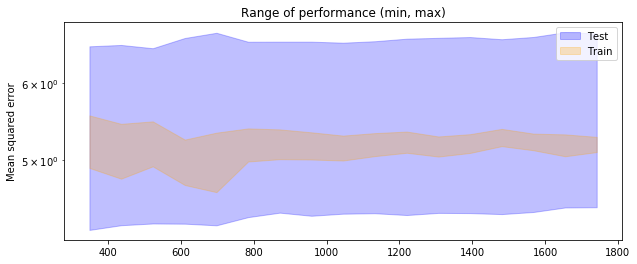

In [78]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.min(1),
                -test_scores.max(1), 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.min(1),
                -train_scores.max(1), 
                alpha=0.25, label='Train', color='orange')

ax.set_title('Range of performance (min, max)')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

In [79]:
from sklearn.model_selection import validation_curve

lambdas =  np.logspace(-2, 6, 12)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train_imdb,
                     y=y_train_imdb,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=10)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

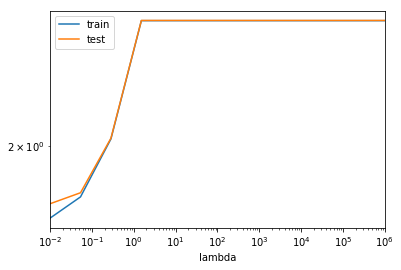

In [80]:
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

In [ ]:

kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

lambdas =  np.logspace(-2, 6, 12)

# outer loops lamda
mseCV = []
for lambda_ in lambdas:
    # inner loops: folds
    mseCV_ = []
    for train_idx, val_idx in folds:
        # train model and compute MSE on test fold
        pipe_3 = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),                           
                           StandardScaler(),
                           Lasso(alpha=lambda_, random_state=1))
        X_train, y_train = X_dev.iloc[train_idx,:], y_dev.iloc[train_idx,:] 
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        pipe_3.fit(X_train, y_train)
        mseCV_.append(mse(pipe_3.predict(X_val),y_val))
        
        
     # STORE result
    mseCV.append(mseCV_)

# convert to DF
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

##### Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
sns.distplot(df_90_income.year, bins = 20);
plt.title("Distribution of movies over the years", size = 10);

In [ ]:
sns.set(style="white")

plt.figure(figsize=(10,5))
plt.title('Movies by the year', size=15)
sns.distplot(df_90_income.year, kde=False)
plt.ylabel('Number of movies', size=15)
plt.xlabel('Year of release',size=15)
plt.axis([1990, 2019, 0, 700])
plt.xticks(np.arange(1990, 2019, step=2))
plt.show()

In [ ]:
# Overview of the different genres 
df_90_income['first_genre'] = df_90_income['genre'].str.split(',').str[0]

a = plt.cm.binary

plt.figure(figsize=(10,4))
count = df_90_income['first_genre'].value_counts()[:7]
sns.barplot(count.values, count.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7)])
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=10)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre name', fontsize=12)
plt.title("Genres", fontsize=15)
plt.show()

In [ ]:
# Overview of movies with highest scores 
top_scored = df_90_income.sort_values(["tomatometer_score","audience_score","metascore","avg_vote"], ascending=False)[
    ["title", "director", "tomatometer_score","audience_score","metascore","avg_vote"]]
top_scored.index = range(len(df_90_income))
top_scored.head(n=10)

In [ ]:
test = df_90_income.sort_values(["year"], ascending=False)[
    ["year","tomatometer_score","audience_score","metascore","avg_vote"]]
test.index = range(len(df_90_income))
#test.head(n=10)


In [ ]:
test.plot(kind="scatter",
                      x="year",
                      y="metascore",
                      alpha=0.4)

plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize = (9,5))
#sns.distplot(df_90_income.tomatometer_score,bins = 50);
#plt.title("Distribution of metascore among movies", size = 10);


# Error: ould not convert string to float: '50%'
#df_90_income = df_90_income[(df_90_income.tomatometer_score.notnull()) &
#                      (df_90_income.audience_score.notnull())]
#sns.jointplot(x=df_90_income['year'], y=df_90_income['tomatometer_score'],
#              kind="kde").fig.set_size_inches(15,15)

# Works but not pretty 
#plt.figure(figsize=[30,10])
#sns.barplot(x=df_90_income.year, y=df_90_income.metascore, data=df_90_income)

In [ ]:
# Ideas:
#1) Look at gender or race in director (men vs women) (balck vs white)

In [ ]:
df_budget.plot(kind="scatter",
                      x="avg_vote",
                      y="net_income",
                      alpha=0.4)